# Claiming forest carbon
This notebook reads, transforms, and plots selected elements of the look-up tables from [Schedule 6 of the Climate Change (Forestry Sector) Regulations 2008](https://www.legislation.govt.nz/regulation/public/2008/0355/latest/DLM1633733.html). 

Note that to view the interactive plots you need to rerun the whole notebook (by clicking the button with symbol resembling >> or by clicking Run All under Cell in the menu).

## Look-up tables
The look-up tables are stored as four separate files in CSV format, e.g. ``./tables-data/table1.csv``, which where fetched from the official website using a script ``./tables-data/fetch.py``. 

These tables contain pre-calculated values for the *cumulative* carbon stock $S_a^T$ measured in tonnes per hectare of a given forest type $T$ and age $a=0,1,\dots,a^{\rm max}_{T}$ (in years), where $a^{\rm max}_{T} = 35$ for $T =$ "Exotic hardwoods" and $a^{\rm max}_{T} = 50$ for the other supported forest types.

Annual carbon stock *change* $s_a^T$ can be calculated using the following formula:

$$
s_a^T = \left\{
\begin{array}{lcl}
0 & \mathrm{for} & a = 0, \\
S_a^T - S_{a-1}^T & \mathrm{for} & a = 1,\dots, a^{\rm max}_{T}.
\end{array} \right.
$$

We now build an interactive plot of $S_{a}^{T}$ and $s_{a}^{T}$ vs $a$ for a given $T$, which can be selected using a drop-down menu.

In [1]:
import pandas as pd             # for handling dataframes
import matplotlib.pyplot as plt # for plotting data
import ipywidgets as widgets    # for interactivity

In [2]:
# Function for calculating annual carbon stock change per hectare
def stock_change(y, T, table):
    return round(table[T][y] - table[T][y-1], 1)

# Function for calling stock_change over the entire time span 
def stock_changes(T, table):
    values=[0]
    for y in range(1, len(table)):
        values.append(stock_change(y,T,table))
    return values

In [3]:
# load first two tables as dataframes and merge into one
table = pd.concat([pd.read_csv('./tables-data/table1.csv'),
                   pd.read_csv('./tables-data/table2.csv')], 
                  axis = 1)

# drop both 'Age' columns, since age matches row index
table.drop('Age (yrs)', inplace = True, axis = 1)

# prepend "P.Radiata" to regionalised Pinus Radiata.
subs = {}
for label in table.columns:
    if(len(label.split()) == 1): 
        subs[label]="P.Radiata in "+label
table = table.rename(columns = subs)

# show first few rows of the final table
table.head(10)

,P.Radiata in Ak,P.Radiata in W/T,P.Radiata in BOP,P.Radiata in Gis,P.Radiata in H/SNI,P.Radiata in N/M,P.Radiata in C/W,P.Radiata in O,P.Radiata in S,Douglas fir,Exotic softwoods,Exotic hardwoods,Indigenous forest
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.5,0.4,0.4,0.6,0.5,0.2,0.2,0.3,0.2,0.1,0.2,0.1,0.6
2,3.0,3.0,2.0,4.0,3.0,1.0,1.0,2.0,1.0,0.1,1.0,3.0,1.2
3,8.0,7.0,6.0,10.0,9.0,3.0,2.0,5.0,3.0,0.4,3.0,13.0,2.5
4,29.0,25.0,24.0,37.0,34.0,12.0,5.0,9.0,14.0,1.0,12.0,34.0,4.6
5,59.0,50.0,51.0,77.0,71.0,28.0,15.0,26.0,35.0,2.0,26.0,63.0,7.8
6,98.0,84.0,84.0,121.0,113.0,48.0,31.0,49.0,65.0,4.0,45.0,98.0,12.1
7,131.0,111.0,118.0,162.0,155.0,73.0,53.0,72.0,99.0,7.0,63.0,137.0,17.5
8,153.0,130.0,143.0,190.0,185.0,100.0,76.0,94.0,134.0,20.0,77.0,176.0,24.0
9,166.0,142.0,155.0,201.0,197.0,117.0,101.0,124.0,160.0,33.0,87.0,214.0,31.6


In [4]:
# Wrap the plotting in a function
def plot_table(T, table):
    
    years = list(range(len(table)))
    stock = list(table[T].values)
    change = stock_changes(T=T,table=table);

    # Instantiate figure with two axes
    fig, axs = plt.subplots(2, figsize=[8.0,6.0], sharex = True)
    
    axs[0].plot(stock)
    axs[0].set_ylim(0)
    axs[0].set_ylabel("carbon stock \n (tons/ha)")
    
    axs[1].bar(x = years, 
               height = change, 
               width = -1.0, # -ve to align with right edge
               align = 'edge')
    axs[1].set_xlim(years[0],years[-1])
    axs[1].set_xlabel("age (years)")
    axs[1].set_ylabel("annual change \n (tons/ha)")

    plt.show()

# Define widget for the forest type
T_widget = widgets.Dropdown(options = list(table.columns), 
                            value = 'Indigenous forest', 
                            description = 'forest type')

# Instantiate an interactive plot
ifig = widgets.interactive(plot_table, 
                           T = T_widget, 
                           table = widgets.fixed(table))

# Show the plot
ifig

interactive(children=(Dropdown(description='forest type', index=12, options=('P.Radiata in Ak', 'P.Radiata in …

## Claim reporting

Now we consider a Claim of carbon stock change in a forest over a number of consecutive years. The calculation requires two additional parameters: $a_{0}$ - the forest age at the start of the first reporting year; and $N$ - the total number of reporting years. Note that the two parameters are not independent, since the underlying look-up tables go up to only $a_{T}^{\rm max}$ years. That is, not only does the calculation require $a_{0} < a_{T}^{\rm max}$, but also $N \leq a_{T}^{\rm max} - a_{0}$, so the range of validity for $N$ depends on the value of $a_{0}$.

We now build an interactive plot of the carbon stock change $s_{a_y}^{T}$ vs reporting years $y=1,\dots,N$, allowing the user to adjust $T$, $a_{0}$, and $N$. The total amount of carbon claimed over $N$ years, i.e. $\sum_{y=1}^{N}s_{a_{y}}^{T}$, will be printed in the plot title.

In [5]:
# Function for calling stock_change over a time window 
def claim_years(N, a0, T, table):
    
    values=[]
    
    for y in range(a0+1, a0+N+1):
        values.append(stock_change(y,T,table))
    
    return values

In [6]:
# Wrap the plotting as a callable function
def plot_claim(N, a0, T, table):
    
    domain = list(range(1,N+1))
    values = claim_years(N = N, a0 = a0, T = T, table = table)
    
    # Instantiate figure for plotting
    fig = plt.figure()
    plt.bar(x = domain, 
            height = values, 
            width = 0.75, # -ve to align with right edge
            align = 'center')
    plt.xlim(domain[0]-0.5,domain[-1]+0.5)
    plt.xlabel("reporting year")
    plt.ylabel("annual change (tons/ha)")
    plt.title('Total claim: '
              +str(round(sum(values),1))+
              ' tons/ha over '+str(N)+' years', fontsize=16)
    plt.show()

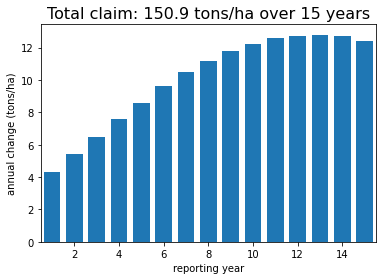

In [7]:
# Show a static example plot
plot_claim(N = 15, 
           a0 = 5, 
           T = 'Indigenous forest', 
           table = table)

In [8]:
# Define widgets for the three parameters
T_widget = widgets.Dropdown(options = list(table.columns[1:]), 
                            value = 'Indigenous forest', 
                            description='$T$')

a0_widget = widgets.IntSlider(value = 0,
                              min = 0,
                              max = 49,
                              description = '$a_{0}$')

N_widget = widgets.IntSlider(value=10, 
                             min=1, 
                             max=50, 
                             description='$N$')

# Special treatment for "Exotic hardwoods"
def update_a0_range(*args):
    if(T_widget.value == 'Exotic hardwoods'):
        a0_widget.max = 35
    else:
        a0_widget.max = 50

T_widget.observe(update_a0_range, 'value')

# Dynamically update the range of validity of N_widget
def update_N_range(*args):
    N_widget.max = a0_widget.max - a0_widget.value

a0_widget.observe(update_N_range, 'value')

# Instantiate an interactive plot
ifig = widgets.interactive(plot_claim, 
                           T = T_widget, 
                           a0 = a0_widget, 
                           N = N_widget, 
                           table = widgets.fixed(table))

# Show the plot
ifig

interactive(children=(IntSlider(value=10, description='$N$', max=50, min=1), IntSlider(value=0, description='$…

## Growth modelling

Here we attempt to fit a couple of simple models to the data in the look-up tables. Since the data itself was generated using (unspecified) models, our attempts can be thought of as reverse engineering or guesstimating the underlying models.

In [9]:
# Import more modules for numerics and curve fitting.
import numpy as np
from scipy.optimize import curve_fit

### Sigmoid growth
The tabulated data for "Indigenous forest" shows a fairly smooth S-shaped (or sigmoidal) growth in carbon stock: the growth starts slowly but accelerates until an inflection point, beyond which growth decelerates and eventually saturates entirely. This is a common pattern which can be modelled using various S-shaped functions.

#### Logistic

Logistic growth refers to S-shaped growth with the time dependence described by the following formula,

$$
Q(t) = \frac{a}{1 + \exp(b(c-t))},
$$

where $Q(t)$ is a time-dependent quantity, $t$ is time, and $a,b,c$ are parameters controlling, respectively, the upper limit, the growth rate, and the position of the inflection point along the time axis. The effects of these parameters can be explored in an interactive plot built below.  

In [10]:
# Define logistic function with the three usual parameters
# and a fourth parameter introduced for vertical ofsetting.
def logistic(t,a=1.0, b=1.0, c=0.0, d=0.0):
    return a/(1.0+np.exp(b*(c-t))) + d

# Define the analytic derivative
def logistic_deriv(t,a=1.0,b=1.0,c=0.0):
    e = np.exp(b*(c-t))
    return a*b*e/(1+e)**2

# Create vectortized versions
vlogistic = np.vectorize(logistic)
vlogistic_deriv = np.vectorize(logistic_deriv)

#### Gompertz
Gompertz growth is another kind of S-shaped growth, where the time dependence is described by a double exponential function:

$$
Q(t)  =  a \exp(-\exp(b(c-t))).
$$

One noteworthy difference between the Gompertz model and the logistic model is that the latter is symmetric about the inflection point while the former is not. This difference is illustrated in plots below.

In [11]:
# Define gompertz function with the three usual parameters
# and a fourth parameter introduced for vertical ofsetting.

def gompertz(t,a=1.0,b=1.0,c=0.0, d=0.0):
    return a*np.exp(-np.exp(b*(c-t))) + d

# Define the anlytic derivative
def gompertz_deriv(t, a=1.0, b=1.0, c=0.0):
    g = np.exp(b*(c-t))
    return a*b*g*np.exp(-g)

# Create vectorised versions
vgompertz = np.vectorize(gompertz)
vgompertz_deriv = np.vectorize(gompertz_deriv)

### Interactive plot
Here we build an interactive plot comparing Gompertz growth with logistic growth, and allowing the user to adjust the three model parameters.

In [12]:
# Wrap the plotting in a function
def plot_models(a,b,c,d):
    
    x=np.linspace(0,50,101,endpoint=True)
    
    fig, axs = plt.subplots(2, figsize=[8.0,6.0], sharex = True)
    
    axs[0].plot(x,vlogistic(x, a, b, c, d), label='Logistic')
    axs[0].plot(x,vgompertz(x, a, b, c, d), label='Gompertz')
    axs[0].set_ylim(0.0)
    axs[0].set_ylabel('quantity Q(t)')
    axs[0].set_title('Growth models' )
    
    axs[1].plot(x,vlogistic_deriv(x, a, b, c), label='Logistic')
    axs[1].plot(x,vgompertz_deriv(x, a, b, c), label='Gompertz')
    axs[1].set_ylim(0.0)
    axs[1].set_xlim(0.0,50.0)
    axs[1].set_xlabel('time units ($t$)')
    axs[1].set_ylabel("time derivative Q'(t)")
    
    axs[1].legend()
    plt.show()

# Define widgets for interactivity
a_widget = widgets.FloatSlider(value = 310.0, 
                               min = 100.0, 
                               max = 500.0,
                               step = 10.0,
                               description = 'limit ($a$)')

b_widget = widgets.FloatSlider(value = 0.16, 
                               min = 0.0, 
                               max = 1.0,
                               step = 0.02,
                               description = 'rate ($b$)')

c_widget = widgets.FloatSlider(value = 16.0, 
                               min = 0.0, 
                               max = 100.0, 
                               description = 'offset ($c$)')

# Instantiate interactive plot
ifig = widgets.interactive(plot_models, 
                           a = a_widget, 
                           b = b_widget, 
                           c = c_widget, 
                           d = widgets.fixed(0))

# Show the plot
ifig

interactive(children=(FloatSlider(value=310.0, description='limit ($a$)', max=500.0, min=100.0, step=10.0), Fl…

### Fitting to data
We can fit our two model functions to the data points in the look-up tables. For comparison, we will fit to data for 'Indigenous forest' and 'P. Radiata in Gis'.

In [13]:
# Wrap the fitting and plotting in a function
def fit_and_plot(T, table):
    
    # Initial parameter values a, b, c, and d
    pini = [350.0,0.1,20.0,0.0]
    
    stock = list(table[T].values)
    age=list(range(len(stock)))
    
    # Optimise parameters and error for Gompertz model
    popt_g, pcov_g = curve_fit(gompertz,age,stock, p0=pini)
    perr_g = np.sqrt(np.diag(pcov_g))

    # Optimise parameters and get error for logistic model
    popt_l, pcov_l = curve_fit(logistic,age,stock, p0=pini)
    perr_l = np.sqrt(np.diag(pcov_l))

    # Build a static plot and show it
    fig, axs = plt.subplots(2, figsize=[8.0,6.0], sharex = True)
    axs[0].plot(age, stock, '.', label='data')
    axs[0].plot(age,vgompertz(age,*popt_g), label='Gompertz')
    axs[0].plot(age,vlogistic(age,*popt_l), label='Logistic')
    axs[0].set_ylabel('carbon stock\n(tons/ha)')
    axs[0].set_xlim(0,50)
    axs[0].set_ylim(0)
    axs[0].set_title(T, fontsize=16)
    axs[0].legend()
    axs[1].plot(age,np.zeros(len(age)), '.', label='data')
    axs[1].plot(age,(vgompertz(age,*popt_g)-stock), label='Gompertz')
    axs[1].plot(age,(vlogistic(age,*popt_l)-stock), label='Logistic')
    axs[1].set_ylabel('deviation\nfrom data')
    axs[1].set_xlabel('age (years)')
    
    # show the plot
    plt.show()
    
    return {'gop':popt_g, 'lop':popt_l}

Apply the ``fit_and_plot()`` function defined above to "Indigenous forest".

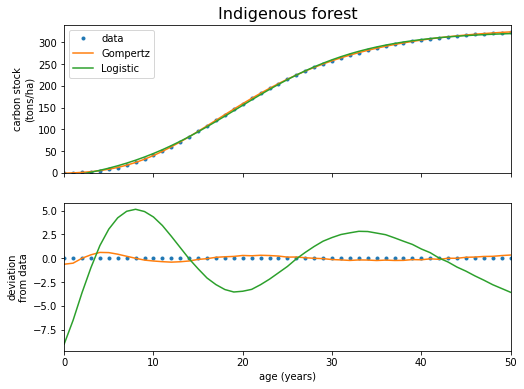

In [14]:
native_oparams = fit_and_plot(T = 'Indigenous forest', table = table)

The plots clearly show that the optimised Gompertz model follows the data more closely than the optimised logistic model. However, both models exhibit smoothly oscillating deviation from the data, suggesting that the data was generated using a more elaborate model. The oscillations become more apparent (for *both* models) when we fit to another forest type, say "P.Radiata in Gis".

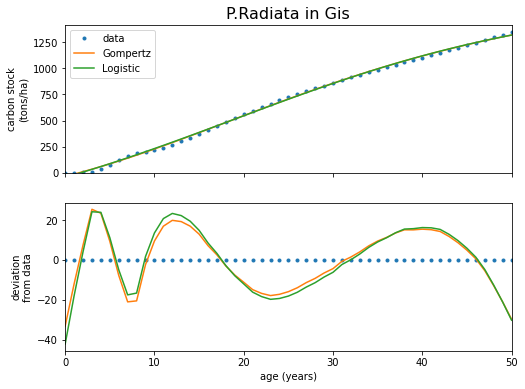

In [15]:
pine_oparams = fit_and_plot(T = 'P.Radiata in Gis', table = table)

In [16]:
# Display the optimised parameter sets
display(native_oparams)
display(pine_oparams)

{'gop': array([ 3.35996569e+02,  1.04146633e-01,  1.70921617e+01, -1.52174896e+00]),
 'lop': array([ 3.55698769e+02,  1.40427036e-01,  1.93155561e+01, -3.11557466e+01])}

{'gop': array([ 2.00656408e+03,  4.39577284e-02,  1.81823052e+01, -2.50332112e+02]),
 'lop': array([ 2.31224235e+03,  5.52206519e-02,  1.90109010e+01, -6.41761243e+02])}

### C_change model

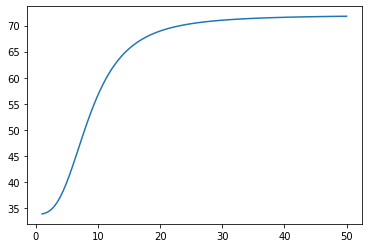

In [17]:
def beets(t, a, b, c, d):
    return (a-d)/(1.0+(t/c)**b) + d

vbeets = np.vectorize(beets)

x=np.linspace(1,50,101,endpoint=True)
plt.plot(x,vbeets(x,a=72.0, b=-2.938, c=8.710, d=33.850))

## Geospatial mapping

Work in progress, but the idea is to show a map of New Zealand with a pinned geolocation, and outline the relevant region for Pinus Radiata (if relevant).